## <p style="text-align: center"> Predicting Professional Tennis Match Outcomes</p>

**Author:**  Carl Toews  
**Date: ** August 8, 2017  

**Project Description:**  This project explores various machine learning techniques on professional tennis data.  The data set was compiled by Jeff Sackman (https://github.com/JeffSackmann/tennis_atp) and consists of the Association of Tennis Professionals (ATP) match outcomes for all major ATP matches since 1968.  In all there are over half a million records.  Features change slightly over the years, but by 2017 include almost 50 elements, including rank, age, seed, and match statistics for both the winner and loser. 


**Outline:**    
I. <a href="#mysql"> MySQL database creation </a>   
II.  <a href="#logisticregression"> Logistic Regression demo:  height and rank difference </a>  
III.  <a href="#svm"> SVM demo:  age and height difference    </a>  
IV.  <a href="#todos"> TODOs </a> 



### I:  <a name="mysql"> MySQL database creation </a>  

The data on Sackman's page is in CSV format.  While it's easy enough to read such data directly into a pandas data structure, one of my goals in this project is to get some practice with the Pandas-MySQL interface.  This section thus creates a MySQL database called "Tennis".  Within "Tennis" are three tables, `matches`, `players`, and `rankings`, corresponding to three different kinds of CSV files (details below.)  The code populates the tables with the appropriate CSV data.  

In [99]:
import sys
# change path name as necessary
sys.path.insert(0, '/Users/ctoews/Projects/Data_Science/Tennis/tennis/mysql')

import setup_mysql_database

Database version : 
('5.7.16',)
Table MATCHES already exists, skipping table creation.
Table PLAYERS already exists, skipping table creation.
Table RANKINGS already exists, skipping table creation.
Table odds already exists, skipping table creation.


### II.  <a name="logisticregression"> Logistic regression demo:   height and rank difference </a>  

The purpose of this code is to implement a very simple logistic regression on two features that can be extended easily to diffent features.  In this simple example, focus on finding a regularized logistic regression classifier based on differences in rank point and height.  

The first step is to extract the relevant data from the MySQL database and save it in a Pandas dataframe.

In [1]:
import numpy as np # numerical libraries
import scipy as sp
import pandas as pd # for data analysis
import pandas.io.sql as sql # for interfacing with MySQL database
from scipy import linalg # linear algebra libraries
from scipy import optimize
from __future__ import division, print_function # good defensive measure
import matplotlib as mpl # a big library with plotting functionality
import matplotlib.pyplot as plt # a subset of matplotlib with most of the useful tools
%matplotlib inline 


/Users/ctoews/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [ ]:
#
# CONFIGURABLE PARAMETERS
#

# name of database
db_name = "tennis"
# name of db user
username = "testuser"
# db password for db user
password = "test623"
# location of atp data files
atpfile_directory = "../data/tennis_atp-master/"
# location of odds data files
oddsfiles_directory = "../data/odds_data/"

#%%

#
# PACKAGES
#

import sqlalchemy # pandas-mysql interface library
import sqlalchemy.exc # exception handling
from   sqlalchemy import create_engine  # needed to define db interface
import glob # for file manipulation
import sys # for defining behavior under errors

#%%

#
# This cell tries to connect to the mysql database "db_name" with the login
# info supplied above.  If it succeeds, it prints out the version number of 
# mysql, if it fails, it exits gracefully.
#

# create an engine for interacting with the MySQL database
try:
    eng_str = 'mysql+mysqldb://' + username + ':' + password + '@localhost/' + db_name
    engine = create_engine(eng_str)
    connection = engine.connect()
    version = connection.execute("SELECT VERSION()")
    print("Database version : ")
    print(version.fetchone())

# report what went wrong if this fails.    
except sqlalchemy.exc.DatabaseError as e:
    reason = e.message
    print("Error %s:" % (reason))
    sys.exit(1)

# close the connection
finally:            
    if connection:    
        connection.close()
    else:
        print("Failed to create connection.")

In [10]:
# extract from MySQL database info on rank points and height for both winner and loser, store in dataframe
with engine.begin() as connection:
    rawdata = pd.read_sql_query("""SELECT winner_rank_points, loser_rank_points, winner_ht, loser_ht FROM matches \
                            WHERE tourney_date > '20160101' \
                            AND winner_rank_points IS NOT NULL \
                            AND loser_rank_points IS NOT NULL \
                            AND winner_ht IS NOT NULL \
                            AND loser_ht IS NOT NULL""", connection)   

We'll be using the scipy function `optimize.minimize` to calculate the classifier.  To make this code as easily generalizable as possible, we derive some quantities of interest from the dataframe and store these in a numpy array.  The array will be the object that we'll manipulate in most of the following calculations.

In [39]:
# this nx2 array contains the differences in rankings points and the differences in height
X = pd.concat([rawdata.iloc[:,1]-rawdata.iloc[:,0],rawdata.iloc[:,3]-rawdata.iloc[:,2]],axis=1).values

# this nx1 binary array indicates whether the match was a "success" or a "failure", as predicted by ranking differences
y = (X[:,0] > 0)

In [40]:
# for numerical well-behavedness, we need to scale and center the data
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)

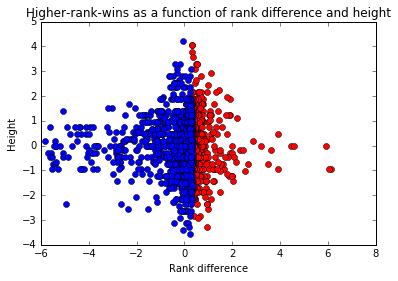

In [41]:
# plot the normalized data
fig, ax = plt.subplots(1,1)
ax.plot(X[y,0],X[y,1],"ro")
ax.plot(X[~y,0],X[~y,1],"bo")
ax.set_xlabel('Rank difference')
ax.set_ylabel('Height')
ax.set_title('Higher-rank-wins as a function of rank difference and height')

In preparation for calculating the regression classifier, we'll prepend a column of 1s to the matrix X and change y into a vector of 1s and 0s (instead of Trues and Falses.)

In [42]:
# change y from True/False binary into 1/0 binary
yv=y*1

# prepend column of 1s to X
Xv=np.insert(X,0,1,axis=1)

To perform the regression, we'll need to define the sigmoid function and a cost function.  The former can take a scalar, vector, or matrix, and return the elementwise value of

$$
\frac{1}{1+e^{-z}}
$$

In [43]:
def sigmoid(z):
    '''
    Usage:  sigmoid(z)
    
    Description:  Computes value of sigmoid function for scalar.  
    For vector or matrix, computes values of sigmoid function for each entry.
    '''

    return 1/(1+np.exp(-z));

The cost function is designed to take a regularization parameter lambda.  For a non-regularized solution, lambda can be set equal to 0.  The cost function returns both a cost and the gradient for any given value of parameters $\theta$.

In [44]:
# define a cost function
def costFunction(theta,X,y,lam):
    '''
    Computes the cost and gradient for logistic regression.
    
    Input: 
           theta (3x1 vector of parameters)
           X (nx3 matrix of feature values, first column all 1s)
           y (nx1 binary vector of outcomes, 1=higher ranked player won, 0 otherwise)
           lam (scalar:  regularization paramter)
           
    Output:  
           cost (scalar value of cost)
    '''

    # number of data points
    m = len(y) 
    # make sure vectors are column vectors
    theta = theta.reshape(-1,1)
    y = y.reshape(-1,1)
    
    # input to sigmoid function will be a column vector
    z = np.dot(X,theta)
    
    # cost function
    J = (1/m)*np.sum(np.dot(-y.transpose(),np.log(sigmoid(z))) - \
                     np.dot((1-y.transpose()),np.log(1-sigmoid(z)))) + \
                    (lam/(2*m))*np.sum(theta[1:len(theta)+1]**2);
  
    # gradient
    regterm = np.insert(theta[1:len(theta)+1],0,0)
    grad = (1/m)*np.sum((sigmoid(z) - y)*X,0) + (lam/m)*regterm
    
    
    return J, grad

Small test:  make sure the cost function works.

In [45]:
# check that cost function works
theta = np.array([1,2,3])
lam = 10
cost, grad = costFunction(theta, Xv, yv,lam)
print("cost:", cost)
print("grad:", grad)

cost: 1.29946958378
grad: [ 0.26942472 -0.03571902  0.26823577]


For diagnostic purposes, we define a `callback` function that will print information about the state and gradient as the optimization algorithm proceeds.  

In [46]:
def callbackF(theta):
    global NFeval
    global Xv
    global yv
    global lam
    cost,grad = costFunction(theta,Xv,yv,lam)
    print("%4d   %3.6f   %3.6f   %3.6f   %3.6f   %3.6f  %3.6f  %3.6f" % \
          (NFeval, theta[0], theta[1], theta[2], cost, grad[0], grad[1], grad[2]))  
    NFeval+=1

Finally, we run the optimization.

In [47]:
# run optimization
NFeval = 1
initial_theta = np.array([0.,0.,0.])
print("iter      t1          t2         t3     cost      grad1       grad2       grad3")
res = sp.optimize.minimize(lambda t:  costFunction(t,Xv,yv,lam), initial_theta, method='CG',\
                           jac=True,options={'maxiter':100,'disp':True}, callback=callbackF)                             

iter      t1          t2         t3     cost      grad1       grad2       grad3
   1   -0.740816   1.011169   0.161153   0.519604   0.001231  -0.080409  0.003482
   2   -0.766671   2.699759   0.088021   0.444510   0.074391  -0.015776  -0.010322
   3   -1.533401   3.437692   0.168184   0.411394   -0.031067  -0.032453  0.002383
   4   -1.913539   5.112970   0.226093   0.385213   -0.014478  -0.010628  0.012251
   5   -1.841148   5.166111   0.164837   0.383704   -0.001019  -0.006336  0.003867
   6   -1.825615   5.262697   0.105890   0.383276   0.005550  -0.003698  -0.004615
   7   -2.043369   5.819243   0.109833   0.381571   -0.003820  -0.001779  -0.003691
   8   -2.033859   5.852652   0.128463   0.381466   -0.000803  -0.000636  -0.000935
   9   -2.029844   5.855832   0.133140   0.381460   -0.000024  -0.000385  -0.000249
  10   -2.029460   5.862014   0.137136   0.381458   0.000325  -0.000234  0.000331
  11   -2.044176   5.898339   0.136527   0.381451   -0.000347  -0.000141  0.000250
  12  

To see how it did, we replot the data with the logistic classifier superimposed over the top.

(-5, 5)

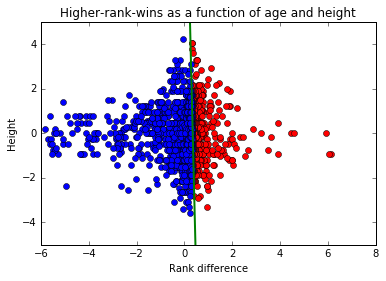

In [51]:
# plot the normalized data with regression line
theta = res.x
fig, ax = plt.subplots(1,1)
ax.plot(X[y,0],X[y,1],"ro")
ax.plot(X[~y,0],X[~y,1],"bo")
xplot = np.array([-1,1])
yplot = (-1/theta[2])*(theta[1]*xplot+theta[0])
ax.plot(xplot,yplot,'g',linewidth=2)
ax.set_xlabel('Rank difference')
ax.set_ylabel('Height')
ax.set_title('Higher-rank-wins as a function of age and height')
ax.set_ylim((-5,5))

**Comments:**

The above procedure turns tennis match outcomes into training data by assigning 1s to matches in which the higher ranked opponent won.  

TODO: 

1.  investigate other methods of classifying matches as 1s or 0s
2.  investigate other combinations of features to use for the regression
3.  test feature choices by dividing data set into training, validation, and test sets


## III.  <a name="svm"> SVM Demo </a>

This section uses some basic `scikit` functionality to train an SVM classifier on rank and ace data. The example is again a trivial one, but defines a workflow and sets the stage for investigating more complex relations.

In [52]:
# we'll use the SVM package in the scikit library
from sklearn import svm

After classifying the SVM classifier, we'll need some helper functions to form contour plots. These helper functions are borrowed from the `scikit` documentation, http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html#sphx-glr-auto-examples-svm-plot-iris-py.

In [53]:
# produce a dense grid of points in rectangle around the data
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

# produce a contour plot with predicted outcomes from SVM classifier
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

We'll run our test on a slightly different set of data than last time.  Here, we'll still classify matches as `1` if the higher ranked player wins and `0` otherwise, but we'll focus on age and height as our predictive features.  

In [54]:
# extract from MySQL database info on rank points and height for both winner and loser, store in dataframe
with engine.begin() as connection:
    rawdata = pd.read_sql_query("""SELECT winner_rank_points, loser_rank_points, winner_age, loser_age, winner_ht, loser_ht \
                            FROM matches \
                            WHERE tourney_date > '20170101' \
                            AND winner_rank_points IS NOT NULL \
                            AND loser_rank_points IS NOT NULL \
                            AND winner_age IS NOT NULL \
                            AND loser_age IS NOT NULL \
                            AND winner_ht IS NOT NULL \
                            AND loser_ht IS NOT NULL""", connection)   

In [55]:
# this nx2 array contains the differences in ages and the differences in height
X = pd.concat([rawdata.iloc[:,2]-rawdata.iloc[:,3], \
               rawdata.iloc[:,4]-rawdata.iloc[:,5]], axis=1).values

# this nx1 binary array indicates whether the match was a "success" or a "failure", as predicted by ranking differences
y = (rawdata.iloc[:,0]-rawdata.iloc[:,1]).values > 0

In [56]:
# for numerical well-behavedness, we need to scale and center the data
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)

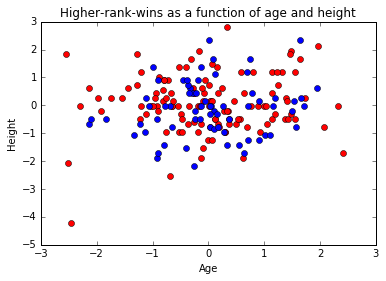

In [57]:
# plot the normalized data 
fig, ax = plt.subplots(1,1)
ax.plot(X[y,0],X[y,1],"ro")
ax.plot(X[~y,0],X[~y,1],"bo")
ax.set_xlabel('Age')
ax.set_ylabel('Height')
ax.set_title('Higher-rank-wins as a function of age and height')

We'll  use the `scikit` svm package to train an SVM classifier on this data.  We'll plot the results as a contour graph.

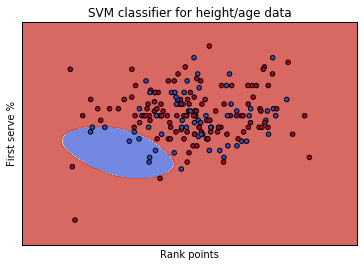

In [58]:
# find the SVM classifier
clf = svm.SVC()
clf.fit(X, y) 

# generate a dense grid for producing a contour plot
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

# feed the grid into the plot_contours routinge
fig, ax = plt.subplots(1, 1)
plot_contours(ax, clf, xx, yy,
              cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Rank points')
ax.set_ylabel('First serve %')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('SVM classifier for height/age data')

Note that these features produce a fairly mixed set of points, so they are unlikely to be highly predictive.  But it is interesting to note the pocket of blue in the lower left corner:  it suggests that, all other being equal, players who are younger and shorter are likely to fair worse than predicted.  

## IV.  Betting

Here we explore the profitability of our algorithms.

In [2]:
# name of database
db_name = "tennis"
# name of db user
username = "testuser"
# db password for db user
password = "test623"
# location of atp data files
atpfile_directory = "../data/tennis_atp-master/"
# location of odds data files
oddsfiles_directory = "../data/odds_data/"

#%%

#
# PACKAGES
#

import sqlalchemy # pandas-mysql interface library
import sqlalchemy.exc # exception handling
from   sqlalchemy import create_engine  # needed to define db interface
import glob # for file manipulation
import sys # for defining behavior under errors

#%%

#
# This cell tries to connect to the mysql database "db_name" with the login
# info supplied above.  If it succeeds, it prints out the version number of 
# mysql, if it fails, it exits gracefully.
#

# create an engine for interacting with the MySQL database
try:
    eng_str = 'mysql+mysqldb://' + username + ':' + password + '@localhost/' + db_name
    engine = create_engine(eng_str)
    connection = engine.connect()
    version = connection.execute("SELECT VERSION()")
    print("Database version : ")
    print(version.fetchone())

# report what went wrong if this fails.    
except sqlalchemy.exc.DatabaseError as e:
    reason = e.message
    print("Error %s:" % (reason))
    sys.exit(1)

# close the connection
finally:            
    if connection:    
        connection.close()
    else:
        print("Failed to create connection.")


Database version : 
('5.7.16',)


In [6]:
# extract from MySQL database info odds
with engine.begin() as connection:
    rawdata = pd.read_sql_query("""SELECT PSW, PSL, WRank, LRank FROM odds \
                            WHERE PSW IS NOT NULL \
                            AND PSL IS NOT NULL \
                            AND WRank IS NOT NULL \
                            AND LRank IS NOT NULL;""", connection)   

In [96]:
investment = len(rawdata)
good_call_idx = (rawdata["LRank"]-rawdata["WRank"]>0)
winner_odds = rawdata["PSW"]
gain = sum(winner_odds*good_call_idx) 
roi = gain - investment

print("total invested:  ", investment)
print("return on investment:  ", roi)

total invested:   20306
return on investment:   -409.649


In [92]:
np.min(winner_odds)

1.0

In [97]:
rawdata

,PSW,PSL,WRank,LRank
0,1.526,2.740,52,88
1,2.140,1.813,105,63
2,1.676,2.360,58,80
3,2.580,1.581,81,32
4,2.170,1.787,119,67
5,1.758,2.220,36,73
6,1.087,9.950,12,306
7,1.121,7.830,7,77
8,1.758,2.220,131,286
9,1.163,6.260,20,251


## IV.  <a name="todos"> TODOs </a>

This work is just the begining part of this analysis.  The gold standard for professional tennis match prediction is to beat the betting market.  There is odds data available for many of these matches, and the proper metric for predictive success is probably percentage increase in profit.

Further work includes the following:

1.  implement a neural net
2.  systematically investigate other combinations of features, including polynomial features
3.  use `join` commands to extract more complex subsets of the data (i.e. court-type specific data, players of a certain origin, players with certain tournament play patterns, etc.)
4.  benchmark algorithms against one another using expected winnings ideas